In [1]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary
import torchvision as tv
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [2]:
# Download the data from torchvision
cdata = tv.datasets.EMNIST(root="emnist", split="letters", download=True)

In [3]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + " classes")

print("\nData size:")
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.view([124800, 1, 28, 28]).float()
print("\nTensor data:")
print(images.shape)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [4]:
# brief aside: class 'N/A' doesn't exist in the data.
print(torch.sum(cdata.targets == 0))

# However, it causes problems in one-hot encoding...
torch.unique(cdata.targets)

cdata.class_to_idx

tensor(0)


{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [5]:
# Remove N/A from the classes
letterCategories = cdata.classes[1:]

# Re-label the labels to start from 0 instead of 1 ( As N/A category starts with 0)
labels = copy.deepcopy(cdata.targets) - 1
print(np.unique(labels))
print(images.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
torch.Size([124800, 1, 28, 28])


In [6]:
# # Image normalization
# plt.hist(images[:10, :, :, :].view(1, -1))
# plt.title("Raw values")
# plt.show()

# Normalize the images
images = images / torch.max(images)

# plt.hist(images[:10, :, :, :].view(1, -1))
# plt.title("Normalized values")
# plt.show()

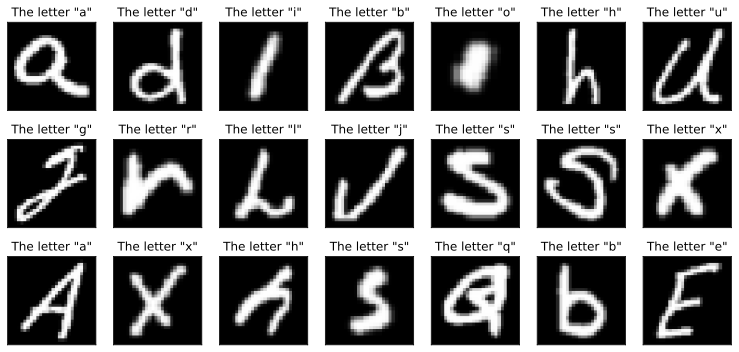

In [7]:
# Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):
    # Pick a random pic
    whichPic = np.random.randint(images.shape[0])

    # Extract the image and its target letter
    I = np.squeeze(images[whichPic, :, :])
    letter = letterCategories[labels[whichPic]]

    # Visualize
    ax.imshow(I.T, cmap="gray")
    ax.set_title('The letter "%s"' % letter)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [8]:
images = images.to(device)
labels = labels.to(device)
# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.05
)

# Step 3: convert into PyTorch Datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Translate into dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device=device),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset.tensors[0].shape[0],
    generator=torch.Generator(device=device),
)

# Verify the shape of the data
print(train_dataset[0][0].device)
print(f"Train dataset shape: {train_loader.dataset.tensors[0].shape}")
print(f"Test dataset shape: {test_loader.dataset.tensors[0].shape}")
print(f"Train dataset Device: {train_loader.dataset.tensors[0].device}")
print(f"Test dataset Device: {test_loader.dataset.tensors[0].device}")

cuda:0
Train dataset shape: torch.Size([118560, 1, 28, 28])
Test dataset shape: torch.Size([6240, 1, 28, 28])
Train dataset Device: cuda:0
Test dataset Device: cuda:0


In [9]:
# check size (should be images X channels X width X height
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)
print(device)
print(train_loader.dataset.tensors[0].device)

torch.Size([118560, 1, 28, 28])
torch.Size([118560])
cuda
cuda:0


In [ ]:
# Create the DL model function


def createTheEMNISTNet(print_toggle=False):
    class emnistNet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()
            # print toggle
            self.print = print_toggle

            ### -------------- feature map layers -------------- ###
            # first convolution layer
            self.conv1 = nn.Conv2d(1, 64, 3, padding=2)
            self.bnorm1 = nn.BatchNorm2d(
                64
            )  # input the number of channels in this layer
            # output size: (28+2*2-3)/1 + 1 = 30/2 = 15(/2 b/c maxpool)

            # second convolution layer
            self.conv2 = nn.Conv2d(64, 256, 2, padding=3)
            self.bnorm2 = nn.BatchNorm2d(
                256
            )  # input the number of channels in this layer
            # output size: (15+2*3-2)/1 + 1 = 20/2 = 10 (/2 b/c maxpool)

            # Third convolution layer
            self.conv3 = nn.Conv2d(256, 512, 3)
            self.bnorm3 = nn.BatchNorm2d(
                512
            )  # input the number of channels in this layer
            # output size: (10+2-4)/1 + 1 = 10/2 = 5 (/2 b/c maxpool)

            ### -------------- linear decision layers -------------- ###
            self.fc1 = nn.Linear(4 * 4 * 512, 512)
            self.fc2 = nn.Linear(512, 256)
            self.fc3 = nn.Linear(256, 64)
            self.fc4 = nn.Linear(64, 26)

        def forward(self, x):
            if self.print:
                print(f"Input: {list(x.shape)}")

            # first block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv1(x)
            x = F.max_pool2d(x, 2)
            x = self.bnorm1(x)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.05, training=self.training)
            if self.print:
                print(f"First CPR block: {list(x.shape)}")

            # second block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv2(x)
            x = F.max_pool2d(x, 2)
            x = self.bnorm2(x)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.05, training=self.training)
            if self.print:
                print(f"Second CPR block: {list(x.shape)}")

            # third block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv3(x)
            x = F.max_pool2d(x, 2)
            x = self.bnorm3(x)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.05, training=self.training)
            if self.print:
                print(f"Third CPR block: {list(x.shape)}")

            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print:
                print(f"Vectorized: {list(x.shape)}")

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = F.leaky_relu(self.fc3(x))
            x = self.fc4(x)
            if self.print:
                print(f"Final output: {list(x.shape)}")
            return x

    # Model instance
    net = emnistNet(print_toggle)

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer

In [11]:
net, lossFun, optimizer = createTheEMNISTNet(True)
X, y = next(iter(train_loader))
yHat = net(X)

# Check the output size
print(f"Output size: {yHat.shape}\n")

# Loss Function
loss = lossFun(yHat, torch.squeeze(y))
print(f"Loss: {loss}")

Input: [32, 1, 28, 28]
First CPR block: [32, 64, 15, 15]
Second CPR block: [32, 256, 10, 10]
Third CPR block: [32, 512, 4, 4]
Vectorized: [32, 8192]
Final output: [32, 26]
Output size: torch.Size([32, 26])

Loss: 3.266615629196167


In [12]:
# Function to train the model
def functionToTrainTheModel(epochs=10):

    # Create new model
    net, lossFun, optimizer = createTheEMNISTNet()

    # initialize losses and errors
    trainLoss = torch.zeros(epochs)
    testLoss = torch.zeros(epochs)
    trainErr = torch.zeros(epochs)
    testErr = torch.zeros(epochs)

    # The Loop
    for epoch in range(epochs):
        net.train()

        # Batch loss and errors
        batchLoss = []
        batchErr = []

        for X, y in train_loader:
            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and error for the batch
            batchLoss.append(loss.cpu().item())
            batchErr.append(torch.mean((torch.argmax(yHat, axis=1) != y).float()).cpu().item())
        # End of batch loop

        # Train loss and error
        trainLoss[epoch] = np.mean(batchLoss)
        trainErr[epoch] = 100 * np.mean(batchErr)

        # Test performance
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
            loss = lossFun(yHat, y)
        testLoss[epoch] = loss.cpu().item()
        testErr[epoch] = 100 * torch.mean((torch.argmax(yHat, axis=1) != y).float()).cpu().item()
        # End of epoch
        print(f'Completed Epoch: {epoch+1} / {epochs}')
    # End of training

    return trainLoss, testLoss, trainErr, testErr, net

In [13]:
# Model Training
trainLoss, testLoss, trainErr, testErr, net = functionToTrainTheModel(epochs=10)

Completed Epoch: 1 / 10
Completed Epoch: 2 / 10
Completed Epoch: 3 / 10
Completed Epoch: 4 / 10
Completed Epoch: 5 / 10
Completed Epoch: 6 / 10
Completed Epoch: 7 / 10
Completed Epoch: 8 / 10
Completed Epoch: 9 / 10
Completed Epoch: 10 / 10


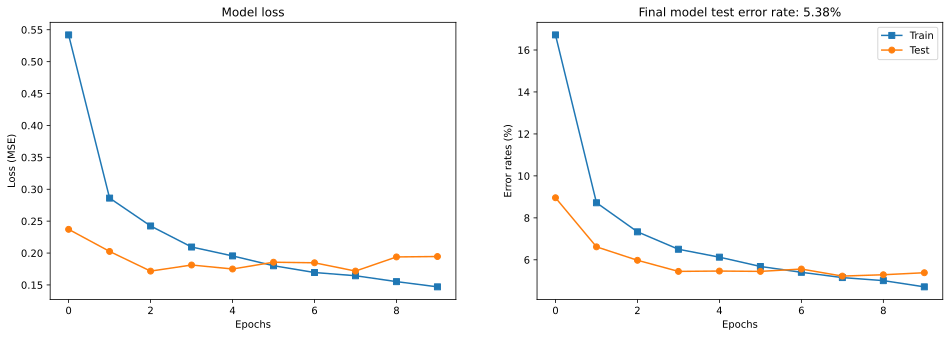

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss.cpu().detach(), "s-", label="Train")
ax[0].plot(testLoss.cpu().detach(), "o-", label="Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_title("Model loss")

ax[1].plot(trainErr.cpu().detach(), "s-", label="Train")
ax[1].plot(testErr.cpu().detach(), "o-", label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error rates (%)")
ax[1].set_title(f"Final model test error rate: {testErr[-1].cpu().detach():.2f}%")
ax[1].legend()

plt.show()